Old Yeller Text Analysis (In total takes about a minute or two to load all sections{previous draft was over 5 minutes})*Remember to upload the downloaded Old Yeller from GitHub to the import section*

In [6]:
!pip install pypdf transformers torch --quiet

from pypdf import PdfReader
import re
import matplotlib.pyplot as plt
from transformers import pipeline
from google.colab import files

In [7]:
# Upload Old Yeller PDF
print("Upload your 'Old Yeller.pdf' file:")
uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]
print(f"Uploaded file: {pdf_path}")

Upload your 'Old Yeller.pdf' file:


Saving Old Yeller.pdf to Old Yeller (2).pdf
Uploaded file: Old Yeller (2).pdf


In [8]:
# Read PDF
reader = PdfReader(pdf_path)
text = ""

for page in reader.pages:
    page_text = page.extract_text()
    if page_text:
        text += page_text + "\n"

print("Extracted characters:", len(text))

Extracted characters: 186079


In [9]:
chapter_names = [
    "ONE","TWO","THREE","FOUR","FIVE","SIX","SEVEN","EIGHT",
    "NINE","TEN","ELEVEN","TWELVE","THIRTEEN","FOURTEEN",
    "FIFTEEN","SIXTEEN"
]

pattern = r"\n(" + "|".join(chapter_names) + r")\s*\n"
splits = re.split(pattern, text)

chapters = {}
for i in range(1, len(splits), 2):
    title = splits[i]
    content = splits[i + 1]
    chapters[title] = content.strip()

print("Chapters found:", len(chapters))

Chapters found: 16


In [10]:
sentiment = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=-1  # CPU
)

Device set to use cpu


In [11]:
chapter_sentiments = {}

for title, content in chapters.items():
    result = sentiment(content, truncation=True, max_length=512)[0]
    score = result["score"] if result["label"] == "POSITIVE" else -result["score"]
    chapter_sentiments[title] = score

average_book_sentiment = sum(chapter_sentiments.values()) / len(chapter_sentiments)
print("\nAverage Book Sentiment:", round(average_book_sentiment, 3))


Average Book Sentiment: -0.987


In [17]:
# Breaks text into manageable chunks for plot-point sentiment
chunk_size = 400
char_chunks = [
    text[i:i + chunk_size]
    for i in range(0, len(text), chunk_size)
]

In [13]:
plot_points = {
    "bear attack": r"bear|bear fight|bear encounter",
    "disease": r"rabies|illness|sick",
    "Old Yeller saves": r"Old Yeller saved|he saved|rescued",
    "Old Yeller dies": r"Old Yeller (was )?shot|put down|died",
    "hunting": r"hunt|hunting|hog hunt"
}

plot_sentiments = {}

for point, pattern in plot_points.items():
    scores = []

    for chunk in char_chunks:
        if re.search(pattern, chunk, re.IGNORECASE):
            result = sentiment(chunk, truncation=True, max_length=512)[0]
            score = result["score"] if result["label"] == "POSITIVE" else -result["score"]
            scores.append(score)

    plot_sentiments[point] = sum(scores)/len(scores) if scores else None

print("\nPlot Point Sentiments:")
for point, score in plot_sentiments.items():
    print(f"{point}: {round(score,3) if score is not None else 'not found'}")


Plot Point Sentiments:
bear attack: -0.463
disease: -0.684
Old Yeller saves: -0.994
Old Yeller dies: -0.8
hunting: -0.597


In [18]:
characters = ["Old Yeller", "Travis", "Arliss", "Mama", "Papa"]
character_sentiments = {}

# Split text into sentence-like chunks
sentences = re.split(r'(?<=[.!?])\s+', text)

for char in characters:
    scores = []

    for s in sentences:
        if char in s:
            result = sentiment(s, truncation=True, max_length=512)[0]
            score = result["score"] if result["label"] == "POSITIVE" else -result["score"]
            scores.append(score)

    character_sentiments[char] = sum(scores) / len(scores) if scores else None

print("\nCharacter Sentiments:")
for char, score in character_sentiments.items():
    print(f"{char}: {round(score,3) if score is not None else 'not mentioned'}")


Character Sentiments:
Old Yeller: -0.124
Travis: -0.23
Arliss: -0.108
Mama: -0.37
Papa: -0.284


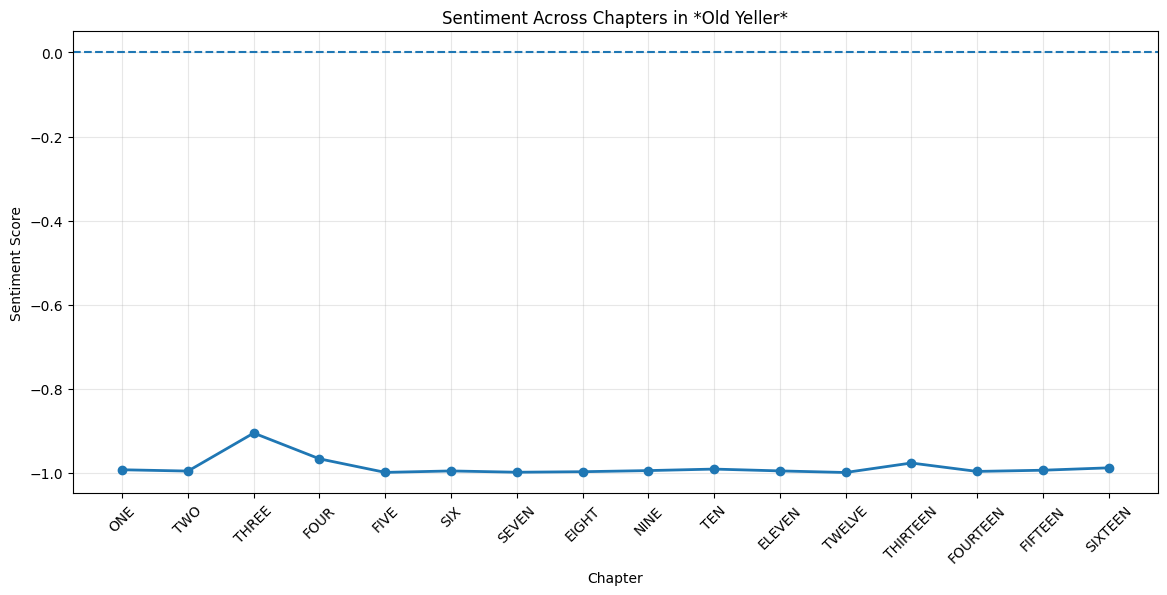

In [16]:
ordered = chapter_names
values = [chapter_sentiments[c] for c in ordered]

plt.figure(figsize=(14,6))
plt.plot(range(1, len(values)+1), values, marker="o", linewidth=2)
plt.axhline(0, linestyle='--')
plt.xticks(range(1, len(values)+1), ordered, rotation=45)
plt.xlabel("Chapter")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Across Chapters in *Old Yeller*")
plt.grid(True, alpha=0.3)
plt.show()

Brief Interpretation: The sentiment is increfibly negative throughout the novel, which makes sense considering it is a sad book. No chapter, person, or event has a positive sentiment. Chapter 3 has the most positive sentiment. The events are very negative, while the characters are still negative, but they are closer to neutral than any other part, with Arliss having the closest sentiment to 0.